# Analysis using FlowMachine directly

## Mobile Data Usage

In this worked example we assume the role of an analyst within the MNO who has been granted access to use FlowMachine directly without going through FlowAPI. Our aim is to investigate how the number of mobile data session (MDS) events varies with the time of day.

### Load FlowMachine and connect to FlowDB

We start by importing the FlowMachine library. We also import [geopandas](http://geopandas.org/) and [mapboxgl](https://mapbox-mapboxgl-jupyter.readthedocs-hosted.com/en/latest/), which we will use later to to visualise the data.

Mapbox requires an [access token](https://www.mapbox.com/account/), which should be set as the environment variable `MAPBOX_ACCESS_TOKEN`.

In [9]:
import flowmachine
import os
import geopandas as gpd
import mapboxgl
from mapboxgl.utils import (
    create_color_stops,
    create_weight_stops,
    df_to_geojson,
)

mapbox_token = os.getenv("MAPBOX_ACCESS_TOKEN")

Next, we connect FlowMachine to FlowDB.

In [124]:
flowmachine.connect()

### Get MDS event counts

We create a `TotalLocationEvents` query to calculate the number of MDS events per cell tower, at hourly intervals over the first 6 days of 2016.

In [4]:
data_events_query = flowmachine.features.TotalLocationEvents(
    start="2016-01-01",
    stop="2016-01-07",
    table="events.mds",
    level="versioned-cell",
    interval="hour",
    size=10,
)

{"submodule":"flowmachine.core.query","event":"events.mds added to cache.","logger":"flowmachine.debug","level":"debug","timestamp":"2019-05-10T11:44:04.546703Z"}
{"submodule":"flowmachine.core.query","event":"events.mds added to cache.","logger":"flowmachine.debug","level":"debug","timestamp":"2019-05-10T11:44:04.546703Z"}
{"submodule":"flowmachine.core.table","event":"Checking provided columns ['location_id', 'datetime'] against db columns ('id', 'datetime', 'duration', 'volume_total', 'volume_upload', 'volume_download', 'msisdn', 'location_id', 'imsi', 'imei', 'tac', 'operator_code', 'country_code')","logger":"flowmachine.debug","level":"debug","timestamp":"2019-05-10T11:44:04.551822Z"}
{"submodule":"flowmachine.core.table","event":"Checking provided columns ['location_id', 'datetime'] against db columns ('id', 'datetime', 'duration', 'volume_total', 'volume_upload', 'volume_download', 'msisdn', 'location_id', 'imsi', 'imei', 'tac', 'operator_code', 'country_code')","logger":"flowma

{"submodule":"flowmachine.core.query","event":"events.mds_20160121 added to cache.","logger":"flowmachine.debug","level":"debug","timestamp":"2019-05-10T11:44:05.440938Z"}
{"submodule":"flowmachine.core.query","event":"events.mds_20160121 added to cache.","logger":"flowmachine.debug","level":"debug","timestamp":"2019-05-10T11:44:05.440938Z"}
{"submodule":"flowmachine.core.query","event":"events.mds_20160122 added to cache.","logger":"flowmachine.debug","level":"debug","timestamp":"2019-05-10T11:44:05.479164Z"}
{"submodule":"flowmachine.core.query","event":"events.mds_20160122 added to cache.","logger":"flowmachine.debug","level":"debug","timestamp":"2019-05-10T11:44:05.479164Z"}
{"submodule":"flowmachine.core.query","event":"events.mds_20160123 added to cache.","logger":"flowmachine.debug","level":"debug","timestamp":"2019-05-10T11:44:05.518545Z"}
{"submodule":"flowmachine.core.query","event":"events.mds_20160123 added to cache.","logger":"flowmachine.debug","level":"debug","timestamp"

{"submodule":"flowmachine.core.query","event":"events.mds_20160214 added to cache.","logger":"flowmachine.debug","level":"debug","timestamp":"2019-05-10T11:44:06.418742Z"}
{"submodule":"flowmachine.core.query","event":"events.mds_20160214 added to cache.","logger":"flowmachine.debug","level":"debug","timestamp":"2019-05-10T11:44:06.418742Z"}
{"submodule":"flowmachine.core.query","event":"events.mds_20160215 added to cache.","logger":"flowmachine.debug","level":"debug","timestamp":"2019-05-10T11:44:06.455475Z"}
{"submodule":"flowmachine.core.query","event":"events.mds_20160215 added to cache.","logger":"flowmachine.debug","level":"debug","timestamp":"2019-05-10T11:44:06.455475Z"}
{"submodule":"flowmachine.core.query","event":"events.mds_20160216 added to cache.","logger":"flowmachine.debug","level":"debug","timestamp":"2019-05-10T11:44:06.492331Z"}
{"submodule":"flowmachine.core.query","event":"events.mds_20160216 added to cache.","logger":"flowmachine.debug","level":"debug","timestamp"

Then we call the `get_dataframe` method to run this query and get the result as a `pandas` DataFrame.

In [5]:
data_events = data_events_query.get_dataframe()

Next, we sum over the six days to get total hourly counts per cell tower location.

In [119]:
events_per_hour = (
    data_events.groupby(["lon", "lat", "hour"]).sum().reset_index()
)

### Visualise data events on a heatmap

We can easily view the total MDS event count per hour using the `plot` method of `events_per_hour`.

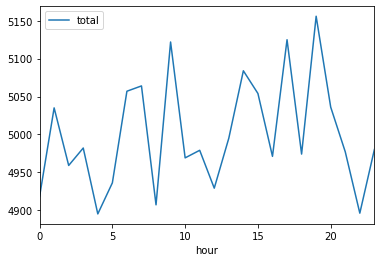

In [122]:
%matplotlib inline

events_per_hour.groupby("hour").sum().plot(y="total")

We can use the `Mapbox GL` library to display a heatmap of our MDS event counts for a particular hour.

In [116]:
hour_to_show = 0

events_per_hour_geodataframe = gpd.GeoDataFrame(
    events_per_hour,
    geometry=gpd.points_from_xy(events_per_hour.lon, events_per_hour.lat),
)

heatmap_viz = mapboxgl.HeatmapViz(
    events_per_hour_geodataframe[
        events_per_hour_geodataframe.hour == hour_to_show
    ].__geo_interface__,
    access_token=mapbox_token,
    weight_property=total,
    weight_stops=create_weight_stops([0, 0.2, 2, 20, 200]),
    color_stops=create_color_stops([0.01, 0.25, 0.5, 0.75, 1], colors=RdPu),
    radius_stops=[[0, 0], [5.5, 16], [15, 200]],  # increase radius with zoom
    opacity=0.8,
    below_layer=waterway - label,
    center=(84.1, 28.4),
    zoom=5.5,
)

heatmap_viz.show()